## 1. Setup

In [ ]:
import pandas as pd
import optuna
import seaborn as sns
import shap
from catboost import CatBoostClassifier, Pool
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    make_scorer,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from sklearn.model_selection import TunedThresholdClassifierCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder

from utils.data_manager import DataManager
from utils.metrics import confusion_curve, cost_curve, cost_score
from utils.data_preprocessor import DataPreprocessor
import utils.plot as plot

In [4]:
sns.set_theme(style="whitegrid")

data_manager = DataManager()

In [5]:
TRAIN_PATH = "data/fraudTrain.csv"
TEST_PATH = "data/fraudTest.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

## 2. Preprocess Data

In [6]:
X_train_full, y_train_full = train_df.drop("is_fraud", axis=1), train_df["is_fraud"]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop("is_fraud", axis=1),
    train_df["is_fraud"],
    test_size=0.2,
    shuffle=False,
)

X_test, y_test = test_df.drop("is_fraud", axis=1), test_df["is_fraud"]

In [9]:
dp = DataPreprocessor()
X_train_pr = dp.transform_fit(X_train)
X_val_pr = dp.transform(X_val)

In [10]:
dp_full = DataPreprocessor()
X_train_full_pr = dp_full.transform_fit(X_train_full)
X_test_pr = dp_full.transform(X_test)

In [ ]:
valid_pool = Pool(X_val_pr, y_val, cat_features=dp.categories)
train_pool = Pool(X_train_pr, y_train, cat_features=dp.categories)

train_full_pool = Pool(X_train_full_pr, y_train_full, cat_features=dp_full.categories)

## 3. Baseline

In [12]:
cost_scorer = make_scorer(
    cost_score, amounts=X_val_pr["n_amt"], greater_is_better=False
)

In [13]:
class BoolToIntTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        bool_cols = X.select_dtypes(include="bool").columns
        X[bool_cols] = X[bool_cols].astype(int)
        return X

In [ ]:
baseline = Pipeline(
    [
        ("bool_to_int", BoolToIntTransformer()),
        ("target_encoder", TargetEncoder()),
        ("classifier", LogisticRegression(random_state=42, max_iter=1000)),
    ]
)
baseline.fit(X_train_pr, y_train)

In [ ]:
tuned_baseline = TunedThresholdClassifierCV(estimator=baseline, cv="prefit", scoring=cost_scorer, refit=False)  # type: ignore
tuned_baseline.fit(X_val_pr, y_val)

In [16]:
y_pred_proba = tuned_baseline.predict_proba(X_test_pr)[:, 1]
y_pred = tuned_baseline.predict(X_test_pr)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
cost = cost_score(y_test, y_pred, X_test_pr["n_amt"])
f1 = f1_score(y_test, y_pred)
b_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f"ROC AUC: {roc_auc:.4f}")  # 0.7698
print(f"Cost: {cost:.4f}")  # 56944.1094
print(f"F1: {f1:.4f}")  # 0.0841
print(f"Balanced Accuracy: {b_accuracy:.4f}")  # 0.5243

ROC AUC: 0.7698
Cost: 56944.1094
F1: 0.0841
Balanced Accuracy: 0.5243


## 4. Hyperparameter Optimization

In [18]:
def objective(trial: optuna.Trial) -> float:
    params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "verbose": 0,
        "metric_period": 5,
        "task_type": "GPU",
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 5.0),
        "random_strength": trial.suggest_float("random_strength", 0.5, 20.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "od_type": "Iter",
        "od_wait": 50,
    }

    model = CatBoostClassifier(**params)

    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

    return model.best_score_["validation"]["AUC"]

In [ ]:
study = optuna.create_study(
    direction="maximize",
    storage=data_manager.get_study_storage(),
    study_name="final_model",
)
study.optimize(objective, n_trials=100)

In [ ]:
best_params = study.best_params
data_manager.save_params(best_params)
print("Best Params:", best_params)

Best Params: {'depth': 9, 'learning_rate': 0.0472387409173478, 'l2_leaf_reg': 0.8499982608088839, 'bagging_temperature': 0.8301618112792768, 'random_strength': 2.817316879121695, 'border_count': 200}


## 5. Threshold Selection

In [ ]:
model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=200,
    metric_period=5,
    task_type="GPU",
    od_type="Iter",
    od_wait=50,
    **best_params
)
model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

In [ ]:
tuned_model = TunedThresholdClassifierCV(estimator=model, cv="prefit", scoring=cost_scorer, refit=False)  # type: ignore
tuned_model.fit(X_val_pr, y_val)

In [ ]:
best_threshold = float(tuned_model.best_threshold_)
print(f"Threshold: {best_threshold:.4f}")

Threshold: 0.0505


In [26]:
y_pred_proba = tuned_model.predict_proba(X_val_pr)[:, 1]
y_pred = tuned_model.predict(X_val_pr)

In [27]:
confusion_thresholds, (tns, fps, fns, tps) = confusion_curve(y_val, y_pred_proba)
cost_thresholds, costs = cost_curve(y_val, y_pred_proba, X_val_pr["n_amt"])

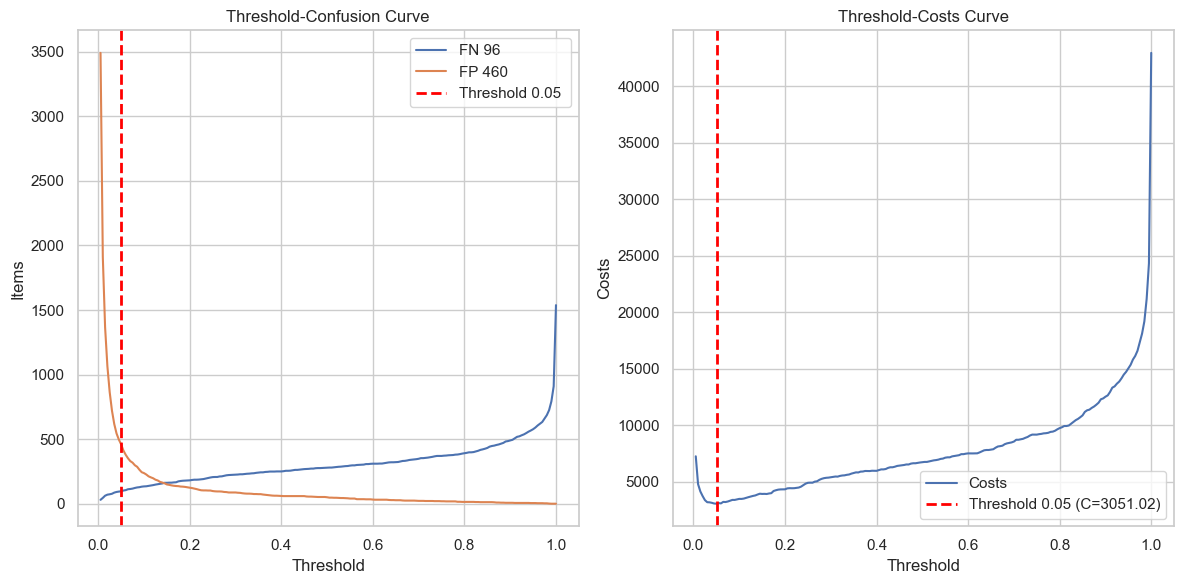

In [28]:
plot.threshold_curve(
    best_threshold, confusion_thresholds, fns, fps, cost_thresholds, costs
)

In [ ]:
roc_auc = roc_auc_score(y_val, y_pred_proba)
cost = cost_score(y_val, y_pred, X_val_pr["n_amt"])
f1 = f1_score(y_val, y_pred)
b_accuracy = balanced_accuracy_score(y_val, y_pred)

print(f"ROC AUC: {roc_auc:.4f}")  # 0.9990
print(f"Cost: {cost:.4f}")  # 3048.6860
print(f"F1: {f1:.4f}")  # 0.8397
print(f"Balanced Accuracy: {b_accuracy:.4f}")  # 0.9676

ROC AUC: 0.9990
Cost: 3048.6860
F1: 0.8397
Balanced Accuracy: 0.9676


## 6. Final Model

In [ ]:
final_model = CatBoostClassifier(
    loss_function="Logloss", verbose=200, task_type="GPU", **best_params
)
final_model.fit(train_full_pool, use_best_model=False)

In [38]:
final_model.set_probability_threshold(best_threshold)

## 7. Result Summary

### 7.1 Metrics

In [39]:
y_pred_proba = final_model.predict_proba(X_test_pr)[:, 1]
y_pred = final_model.predict(X_test_pr)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
cost = cost_score(y_test, y_pred, X_test_pr["n_amt"])
f1 = f1_score(y_test, y_pred)
b_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f"ROC AUC: {roc_auc:.4f}")  # 0.9977
print(f"Cost: {cost:.4f}")  # 6295.7695
print(f"F1: {f1:.4f}")  # 0.8079
print(f"Balanced Accuracy: {b_accuracy:.4f}")  #  0.9474

ROC AUC: 0.9977
Cost: 6295.7695
F1: 0.8079
Balanced Accuracy: 0.9474


### 7.2. Curves

In [41]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)

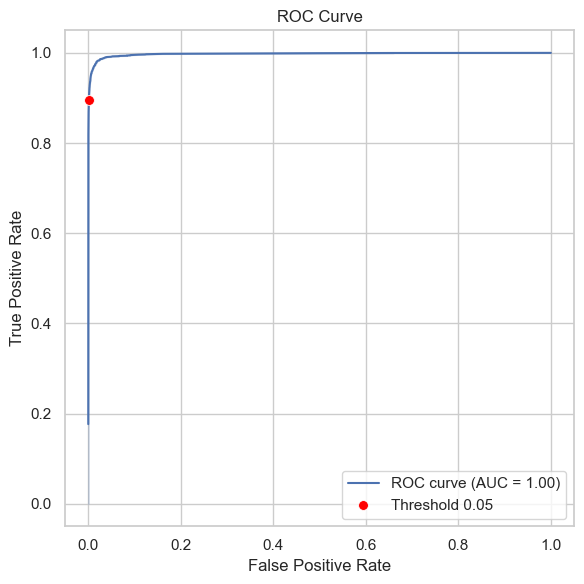

In [42]:
plot.roc_curve(best_threshold, roc_thresholds, fpr, tpr)

In [43]:
precision, recall, pre_rec_thresholds = precision_recall_curve(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)

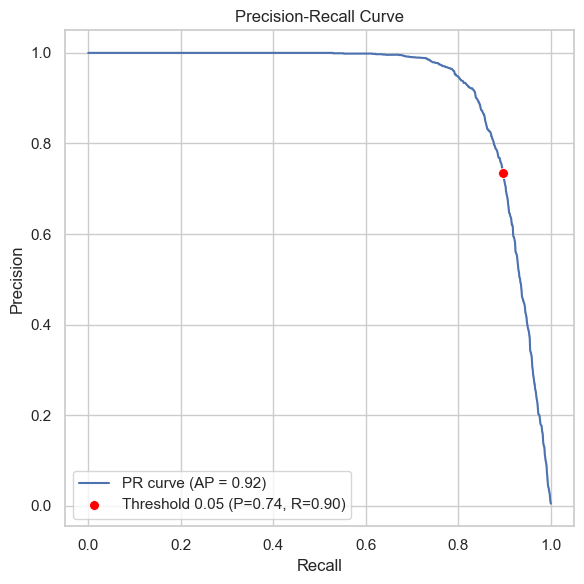

In [44]:
plot.precision_recall_curve(best_threshold, pre_rec_thresholds, precision, recall, ap)

In [45]:
confusion_thresholds, (tns, fps, fns, tps) = confusion_curve(y_test, y_pred_proba)
cost_thresholds, costs = cost_curve(y_test, y_pred_proba, X_test_pr["n_amt"])

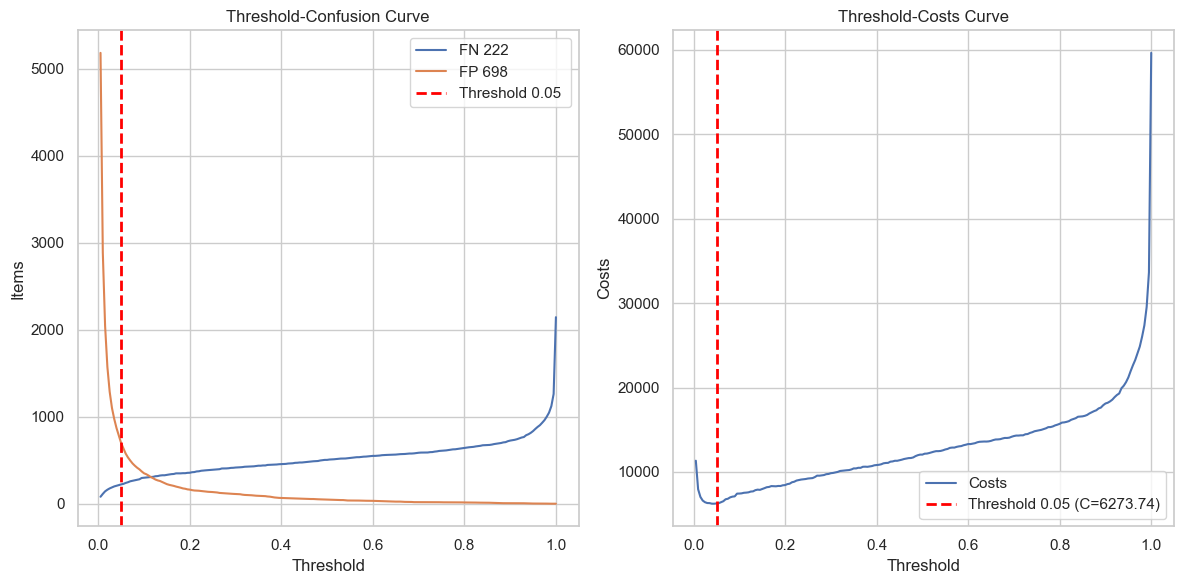

In [46]:
plot.threshold_curve(
    best_threshold, confusion_thresholds, fns, fps, cost_thresholds, costs
)

In [47]:
matrix = confusion_matrix(y_test, y_pred)

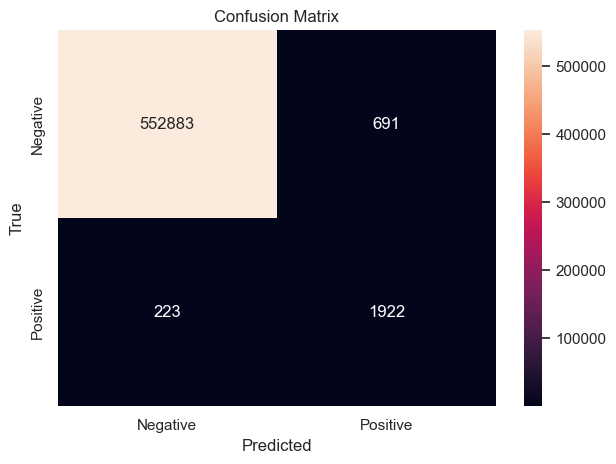

In [48]:
plot.confusion_matrix(matrix)

### 7.3. Feature Importance

In [ ]:
feature_names = final_model.feature_names_

In [ ]:
feature_importance = final_model.get_feature_importance()

importance_df = pd.DataFrame(
    {
        "feature": feature_names,
        "importance": feature_importance,
    }
).sort_values("importance", ascending=False)

importance_df.set_index("feature", inplace=True)

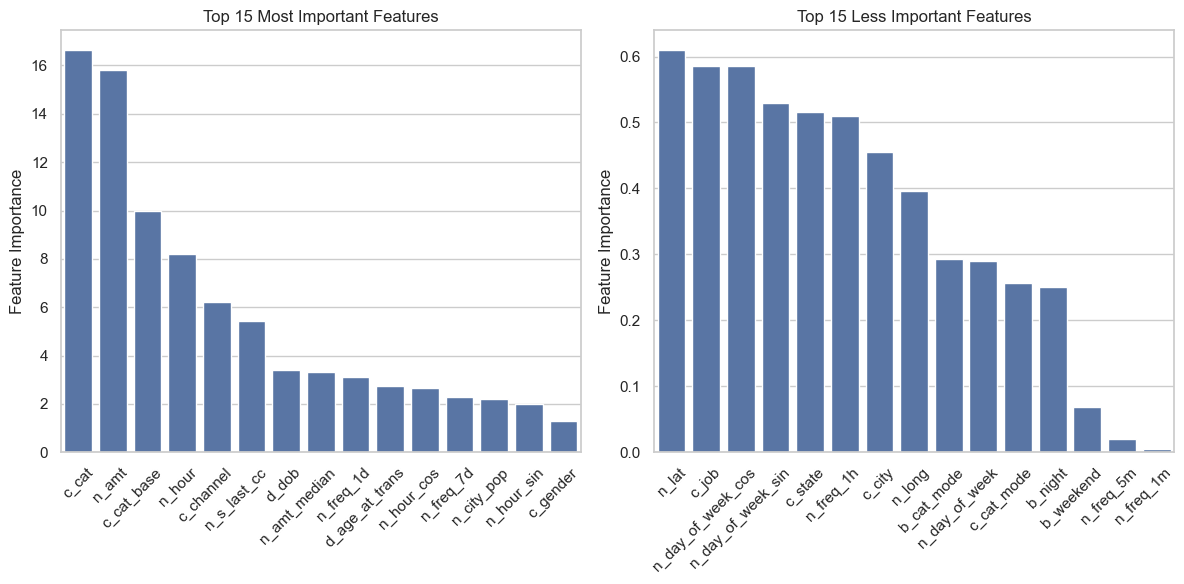

In [51]:
plot.feature_importance(importance_df)

In [87]:
sample = X_train_full_pr.sample(n=10000)
shap_pool = Pool(sample, cat_features=dp_full.categories)
shap_values = final_model.get_feature_importance(shap_pool, type="ShapValues")[:, :-1]  # type: ignore

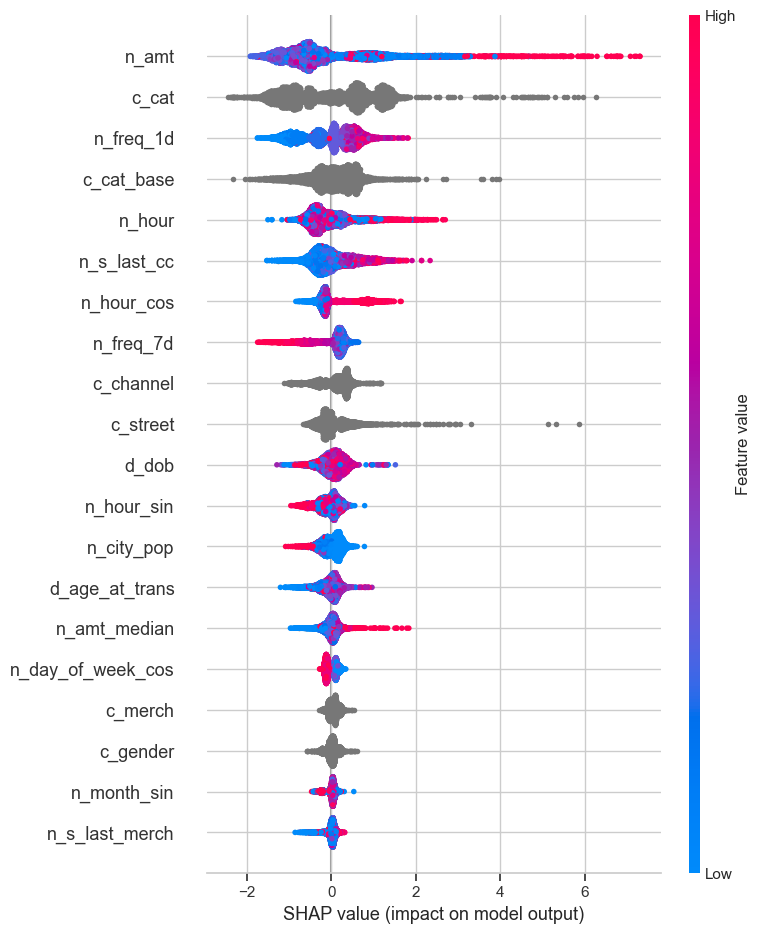

In [88]:
shap.summary_plot(shap_values, sample, plot_type="dot")